# Comparing Bandit Agents

This notebook compares the performance of different bandit agents.

### Imports

In [1]:
from ast import arg
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os, sys

from bart_playground.bandit.sim_util import *
from compare_agents import (
    AgentSpec, compare_agents_across_scenarios, print_summary_results, plot_comparison_results
)
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario

In [2]:
# Define experiment parameters
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
# from bart_playground.bandit.neural_ts_agent import NeuralTSDiagAgent

import multiprocessing

from bart_playground.bart import LogisticBART

cores =  multiprocessing.cpu_count() - 1

In [3]:
from typing import List, Tuple, Any
from bart_playground.bandit.agent import BanditAgent

## Tunable Parameters

In [4]:
# Create test scenarios
np.random.seed(0)
    
scenario_factories = {
    # "Linear": lambda: LinearScenario(P=4, K=3, sigma2=1.0),
    # "LinearOffset": lambda: LinearOffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset": lambda: OffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset2": lambda: OffsetScenario(P=4, K=3, sigma2=0.1),
    # "Friedman": lambda: FriedmanScenario(P=5, K=3, sigma2=1.0, lambda_val=15),
    # "Sparse": lambda: FriedmanScenario(P=50, K=3, sigma2=1.0, lambda_val=5),
    ## "Isolet": lambda: OpenMLScenario('isolet', version=1),
    "Magic": lambda: OpenMLScenario('MagicTelescope', version=1),
    "Adult": lambda: OpenMLScenario('adult', version=2),
    "Shuttle": lambda: OpenMLScenario('shuttle', version=1),
    ## "Letter": lambda: OpenMLScenario('letter', version=1),
    "Mushroom": lambda: OpenMLScenario('mushroom', version=1),
    "Covertype": lambda: OpenMLScenario('covertype', version=3),
    "MNIST": lambda: OpenMLScenario('mnist_784', version=1),
}

# Parse command-line arguments
args = sys.argv[1:]

# Determine which scenarios to run; default to Mushroom if none or invalid
if len(args) == 0 or not any(arg in scenario_factories for arg in args):
    print("No valid scenarios specified, using Mushroom.")
    args = ['Mushroom']

selected_keys = [k for k in scenario_factories if k in args]
scenarios = {key: scenario_factories[key]() for key in selected_keys}

rep_dataset = selected_keys[0]
log_encoding = 'native' if rep_dataset in ['Adult', 'Magic', 'Mushroom'] else 'multi' 

np.random.seed(0)

# import torch
# torch.manual_seed(0)
# torch.cuda.manual_seed_all(42)

No scenarios specified, using Mushroom.


In [5]:
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, MultiChainBARTAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bart import DefaultBART, LogisticBART

all_agent_specs: List[AgentSpec] = [
    ("BCF",        BCFAgent,        {'nskip':100, 'ndpost':100, 'nadd':3, 'nbatch':1, 'random_state':1000}),
    ("BART",       BARTAgent,       {'nskip':50,  'ndpost':50,  'nadd':5,                   'random_state':1000, 'encoding':'multi'}),
    ("LogisticBART", LogisticBARTAgent,{
        'nskip':50,
        'ndpost':50,
        'nadd':1,
        'random_state':1000,
        'encoding':log_encoding
    }),
    ("MCBART",     MultiChainBARTAgent,{
        'bart_class': LogisticBART,
        'n_ensembles': 4,
        'n_trees': 100,
        'nskip': 50,
        'ndpost': 50,
        'nadd': 2,
        'random_state': 1000,
        'encoding': log_encoding
    }),
    ("Ensemble",   EnsembleAgent,   {
        'bcf_kwargs':       dict(nskip=100, ndpost=10, nadd=2, random_state=1000),
        'linear_ts_kwargs': dict(v=1)
    }),
    ("BCF_PSOff",  BCFAgentPSOff,   {'nskip':100, 'ndpost':10, 'nadd':2, 'nbatch':1, 'random_state':1000}),
    ("LinearTS",   LinearTSAgent,   {'v':1}),
    ("LinearTS2",  LinearTSAgent2,  {}),
    # commented out for on-demand testing:
    # ("RoME",             RoMEAgent,              {'featurize':_featurize, 't_max':n_draws, 'pool_users':False}),
    # ("StandardTS",       StandardTSAgent,        {'featurize':_featurize}),
    # ("ActionCenteredTS", ActionCenteredTSAgent,  {'featurize':_featurize}),
    # ("IntelligentPooling", IntelligentPoolingAgent, {'featurize':_featurize, 't_max':n_draws}),
]

In [6]:

# Filter agents to include only those we want to test
agent_specs = [agent for agent in all_agent_specs if agent[0] in ["MCBART", "LinearTS"]]

In [ ]:
n_simulations = 1  # Number of simulations per scenario
max_draws = 300      # Number of draws per simulation

def call_func():
    return compare_agents_across_scenarios(
        scenarios=scenarios,
        agent_specs=agent_specs,
        n_simulations=n_simulations,
        max_draws=max_draws,
        parallel=False
    )

In [7]:
results = call_func()


Evaluating Mushroom scenario...


Simulating sequentially:   0%|          | 0/3 [00:00<?, ?it/s]

Reshuffling scenario for simulation 0...
Dataset mushroom reshuffled with random state 42.


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially:  33%|███▎      | 1/3 [00:49<01:39, 49.92s/it]

Saving temporary results for simulation 0 in mushroom...
Reshuffling scenario for simulation 1...
Dataset mushroom reshuffled with random state 43.


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially:  67%|██████▋   | 2/3 [01:35<00:47, 47.60s/it]

Saving temporary results for simulation 1 in mushroom...
Reshuffling scenario for simulation 2...
Dataset mushroom reshuffled with random state 44.


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially: 100%|██████████| 3/3 [02:23<00:00, 47.73s/it]

Saving temporary results for simulation 2 in mushroom...


## Summary Results

In [8]:
print_summary_results(results)
# Hihihi
# Hihi


=== Mushroom Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 91.67 (±3.30)
  LinearTS2: 90.67 (±0.94)
  LogisticBART: 36.67 (±4.99)

Average computation times (seconds):
  LinearTS: 0.2181 (±0.0119)
  LinearTS2: 0.2332 (±0.0024)
  LogisticBART: 46.7392 (±1.6528)



In [9]:
key, value = next(iter(results.items()))
internal_key, internal_value = next(iter(value['times'].items()))
n_draws = internal_value.shape[1]

## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

In [10]:
# Create results directory if it doesn't exist
results_dir = "./results/agent_comparison_test"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

import pickle
appendix_name = list(scenarios.keys())[0]  # Use the first scenario name as appendix
result_filename = os.path.join(results_dir, f"result_{appendix_name}.pkl")
pickle.dump(results, open(result_filename, "wb"))

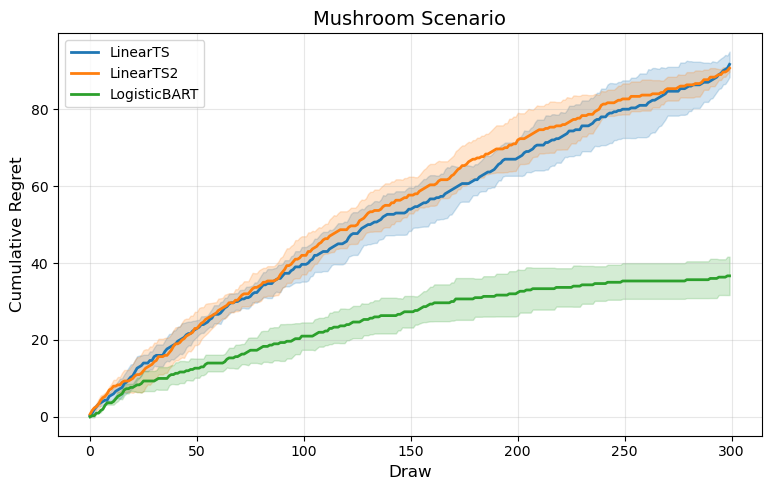

In [11]:
results = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    save_path=f"{results_dir}/agent_comparison_results_{appendix_name}.png",
    show_time=False
)